# Gerekli Kütüphanelerin Eklenmesi

In [1]:
import os
import cv2 as cv
import pickle
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import multiprocessing
from sklearn.svm import SVC
from tensorflow.keras.applications import MobileNet, vgg19
from skimage.feature import local_binary_pattern, hog


C:\Users\yusuf\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def face_dedector(img):

    classifier = cv.CascadeClassifier("haarcascade_frontalface_default.xml")
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    faces = classifier.detectMultiScale(gray,1.5,4)
    if(len(faces)==0):
        return None,None
    else:
        x,y,w,h = faces[0]
    
    return img[y:y+h, x:x+w], [x,y,w,h]

# Veri Setlerinin Yüklenmesi

In [3]:
file_path = 'veri_setleri'

images = []
labels = []
labels_dict = {}
img_size = 96

In [4]:
# -> resimler alındı ve kaydedildi 
'''
for dataset in os.listdir(file_path):
    
    dataset_path = f'{file_path}\\{dataset}'
    
    for index,label in enumerate(os.listdir(dataset_path)):
        
        label_path = f'{dataset_path}\\{label}'
        
        labels_dict[index] = label
        
        for image in os.listdir(label_path):
            
            image_path = f'{label_path}\\{image}'
            
            img = cv.imread(image_path)
            
            # Resimler (img_size x img_size) boyutuna getirildi ve gri tona donusturuldu.
            
            img = cv.resize(img,(img_size,img_size))
            img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
            
            images.append(img)
            labels.append(index)
'''


# AffectNet veri setindeki yüzlerin tespit edilmesi
'''
dataset_path = "veri_setleri\\AffectNet"
save_path = "veri_setleri\\AffectNetFaces"

for index,label in enumerate(os.listdir(dataset_path)):
        
        label_path = f'{dataset_path}\\{label}'
        
        sayac = 0
        
        for image in os.listdir(label_path):
            
            image_path = f'{label_path}\\{image}'
            
            img = cv.imread(image_path)
            
            face = face_dedector(img)[0]
            
            
            if face is not None:
                face = cv.resize(face,(img_size,img_size))
            
                img_name = f"{save_path}\\{label}\\image{sayac}.jpg"
                sayac = sayac + 1
            
                cv.imwrite(img_name, face)
'''


'''
name = f"last_images_x{img_size}.pkl"

with open(name, 'wb') as file:
    pickle.dump(images, file)
with open('last_labels.pkl', 'wb') as file:
    pickle.dump(labels, file)
with open('last_labels_dict.pkl', 'wb') as file:
    pickle.dump(labels_dict, file)
'''

'\nname = f"last_images_x{img_size}.pkl"\n\nwith open(name, \'wb\') as file:\n    pickle.dump(images, file)\nwith open(\'last_labels.pkl\', \'wb\') as file:\n    pickle.dump(labels, file)\nwith open(\'last_labels_dict.pkl\', \'wb\') as file:\n    pickle.dump(labels_dict, file)\n'

In [5]:
name = f"without_fer_images_{img_size}.pkl"
with open(name, 'rb') as file:
    images = pickle.load(file)
with open('without_fer_labels.pkl', 'rb') as file:
    labels = pickle.load(file)
with open('without_fer_labels_dict.pkl', 'rb') as file:
    labels_dict = pickle.load(file)

In [6]:
images
labels_dict

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

# Veri Setlerinin Düzenlenmesi

In [7]:
#diziler numpy dizilerine dönüştürüldü

result_images = np.asarray(images)
images = np.asarray(images)
labels = np.asarray(labels)

In [8]:
print(result_images.shape)
print(labels.shape)

(41510, 96, 96)
(41510,)


In [9]:
images

array([[[ 76,  74,  70, ...,  45,  46,  46],
        [ 75,  73,  68, ...,  43,  44,  44],
        [ 73,  70,  64, ...,  42,  42,  43],
        ...,
        [ 20,  21,  21, ...,  36,  45,  37],
        [ 21,  21,  21, ...,  29,  31,  29],
        [ 19,  20,  21, ...,  23,  29,  23]],

       [[255, 255, 255, ..., 254, 254, 254],
        [255, 255, 255, ..., 254, 254, 254],
        [255, 255, 255, ..., 254, 255, 254],
        ...,
        [255, 255, 255, ..., 254, 255, 255],
        [255, 255, 255, ..., 254, 254, 254],
        [255, 255, 255, ..., 254, 254, 254]],

       [[123, 121, 120, ...,  21,  22,  22],
        [119, 121, 124, ...,  21,  21,  21],
        [122, 120, 117, ...,  21,  21,  21],
        ...,
        [  4,  10,   4, ...,  18,  21,  25],
        [ 13,   4,  27, ...,  93, 233,  20],
        [ 26,   9,  17, ...,  17,  22,  21]],

       ...,

       [[109,  91,  97, ..., 172, 166, 163],
        [ 99,  97, 116, ..., 170, 164, 161],
        [ 90, 108, 141, ..., 167, 161, 158

In [10]:
images = result_images / 255.0

In [11]:
print(f"Toplam resim sayısı: {len(images)}")
print(f"Toplam etiket sayısı: {len(labels)}")

images = images.reshape(-1,img_size,img_size,1)
#images = images.reshape(-1,img_size,img_size,3)
#images = images.reshape((len(images),-1))
print(images.shape)

Toplam resim sayısı: 41510
Toplam etiket sayısı: 41510
(41510, 96, 96, 1)


In [12]:
labels = to_categorical(labels)
print(labels.shape)

(41510, 7)


# Görüntü İşleme

In [13]:
#sobel

def Sobel(result_images):
    result_processed_images = []

    for image in result_images:
        img1 = cv.Sobel(image,cv.CV_8U,0,1)
        img2 = cv.Sobel(image,cv.CV_8U,1,0)
        img3 = cv.Sobel(image,cv.CV_8U,1,1)

        combined_image = cv.add(img1, img2)
        combined_image = cv.add(combined_image, img3)

        result_processed_images.append(combined_image)

    processed_images = np.asarray(result_processed_images)
    processed_images = processed_images / 255.0
    
    return processed_images


#lbp

def Lbp(result_images,radius=1, n_points=8):
    result_processed_images = []

    for image in result_images:
        lbp = local_binary_pattern(image, n_points, radius)
        result_processed_images.append(lbp)

    processed_images = np.asarray(result_processed_images)
    processed_images = processed_images / 255.0
    
    return processed_images

#gauss

def Gauss(result_images,ksize=3):
    result_processed_images = []

    for image in result_images:
        blur = cv.GaussianBlur(image,(ksize,ksize),0)
        result_processed_images.append(blur)

    processed_images = np.asarray(result_processed_images)
    processed_images = processed_images / 255.0
    
    return processed_images

# hog

def Hog(result_images):
    result_processed_images = []

    for image in result_images:
        _,hogg = hog(image,visualize=True)
        result_processed_images.append(hogg)

    processed_images = np.asarray(result_processed_images)
    
    '''
    with open('hog.pkl', 'wb') as file:
        pickle.dump(result_processed_images, file)
    '''    
    return processed_images

In [15]:
processed_images = Hog(result_images)
images = Lbp(result_images,1,8)

In [19]:
with open('hog.pkl', 'rb') as file:
    processed_images = pickle.load(file)
    
processed_images = np.asarray(processed_images)
processed_images = processed_images.reshape(-1,img_size,img_size,1)
#processed_images = processed_images / 255.0

'''
with open('hog.pkl', 'rb') as file:
    images = pickle.load(file)
images = np.asarray(images)
images = images.reshape(-1,img_size,img_size,1)
images = images/255.0
'''

"\nwith open('hog.pkl', 'rb') as file:\n    images = pickle.load(file)\nimages = np.asarray(images)\nimages = images.reshape(-1,img_size,img_size,1)\nimages = images/255.0\n"

In [20]:
images.max()

1.0

In [21]:
processed_images.max()

0.7768293642530254

# Veri Setlerinin Düzgün Okunduğunun Test Edilmesi

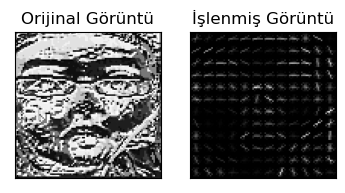

In [22]:
num = np.random.randint(len(labels))

plt.subplot(1, 3, 1)
plt.imshow(images[num], cmap='gray')
plt.xticks([]), plt.yticks([])
plt.title('Orijinal Görüntü')

plt.subplot(1, 3, 2)
plt.imshow(processed_images[num], cmap='gray')
plt.xticks([]), plt.yticks([])
plt.title('İşlenmiş Görüntü')


'''
plt.subplot(1, 3, 3)
plt.imshow(added_images[num], cmap='gray')
plt.title('Orijinal + İslenmis')
'''


'''
plt.subplot(1, 3, 3)
added_image = cv.add(result_images[num], processed_images[num])
plt.imshow(added_image, cmap='gray')
plt.title('Orijinal + LBP')
'''

plt.show()

In [23]:
#processed_images = images
#images = images.reshape(-1,img_size,img_size)
processed_images = processed_images.reshape(-1,img_size,img_size)
#processed_images = processed_images.reshape(-1,img_size,img_size,1)

processed_images = np.stack((images,processed_images),axis=3)

# Veri Setinin Train-Test Şeklinde Bölünmesi

In [24]:
x_train,x_test,y_train,y_test = train_test_split(processed_images,labels,test_size=0.2,random_state=10)

# Modelin Eğitilmesi

In [25]:
print(tf.config.list_physical_devices('GPU'))
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
print(tf.config.list_physical_devices('GPU'))

# GPU ayarlarını yapılandırma
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Bellek sınırlarını tanımla
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])  # 4 GB (4096 MB)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Bellek sınırları yapılandırılamazsa
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [26]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(33208, 96, 96, 2)
(8302, 96, 96, 2)
(33208, 7)
(8302, 7)


In [27]:
emotion_dedection_model = Sequential([
    
    Conv2D(64, (3,3), activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    Conv2D(96, (3,3), activation='relu'),
    Conv2D(96, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    Conv2D(128, (3,3), activation='relu'),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    Conv2D(256, (3,3), activation='relu'),
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    Dropout(0.20),
    
    Flatten(),
    Dense(256,activation='relu'),
    Dense(256,activation='relu'),

    Dense(7,activation='softmax')
])

'''

emotion_dedection_model = Sequential([
    
    Conv2D(128, (10,10), activation='relu'),
    MaxPooling2D((2,2)),
    
    Conv2D(256, (5,5), activation='relu'),
    MaxPooling2D((2,2)),
    
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    Conv2D(128, (3,3), activation='relu'),
    
    #Dropout(0.20),
    
    Flatten(),
    
    Dense(2048,activation='relu'),
    Dense(1024,activation='relu'),

    Dense(7,activation='softmax')
])

'''

'''
emotion_dedection_model = Sequential([
    
    Conv2D(128, (10,10), activation='relu'),
    MaxPooling2D((2,2)),
    
    Conv2D(256, (5,5), activation='relu'),
    MaxPooling2D((2,2)),
    
    
    Conv2D(128, (3,3), activation='relu'),
    
    #Dropout(0.20),
    
    Flatten(),
    
    Dense(2048,activation='relu'),
    Dense(256,activation='relu'),

    Dense(7,activation='softmax')
])
'''
emotion_dedection_model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=.0001),
                                loss = 'categorical_crossentropy',
                                metrics=['accuracy'])


In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

emotion_dedection_model.fit(x_train,y_train,epochs=50,validation_split=0.2,callbacks=[early_stopping])

Epoch 1/50
831/831 [==============================] - 66s 65ms/step - loss: 1.7059 - accuracy: 0.3131 - val_loss: 1.4380 - val_accuracy: 0.4133
Epoch 2/50
831/831 [==============================] - 35s 42ms/step - loss: 1.3125 - accuracy: 0.4780 - val_loss: 1.1958 - val_accuracy: 0.5211
Epoch 3/50
831/831 [==============================] - 34s 41ms/step - loss: 1.1805 - accuracy: 0.5366 - val_loss: 1.1215 - val_accuracy: 0.5613
Epoch 4/50
831/831 [==============================] - 38s 45ms/step - loss: 1.0964 - accuracy: 0.5733 - val_loss: 1.1166 - val_accuracy: 0.5715
Epoch 5/50
831/831 [==============================] - 35s 42ms/step - loss: 1.0310 - accuracy: 0.6014 - val_loss: 1.0594 - val_accuracy: 0.5772
Epoch 6/50
831/831 [==============================] - 41s 49ms/step - loss: 0.9769 - accuracy: 0.6236 - val_loss: 1.0403 - val_accuracy: 0.5912
Epoch 7/50
831/831 [==============================] - 35s 42ms/step - loss: 0.9288 - accuracy: 0.6407 - val_loss: 0.9885 - val_accuracy:

In [29]:
emotion_dedection_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        608       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 42, 42, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 64)       0         
 2D)                                                    

In [30]:
emotion_dedection_model.evaluate(x_test,y_test)

260/260 [==============================] - 3s 12ms/step - loss: 0.9448 - accuracy: 0.6544


[0.9448015689849854, 0.6544206142425537]

In [ ]:
#emotion_dedection_model.evaluate(images,labels)

In [ ]:
tahminler = emotion_dedection_model.predict(x_test)
print(tahminler)

In [ ]:
x_train2,x_test2,y_train2,y_test2 = train_test_split(images,labels,test_size=0.2,random_state=10)

In [ ]:
num = np.random.randint(len(y_test))

plt.subplot(1, 4, 1)
plt.imshow(x_test2[num], cmap='gray')
plt.title('Orijinal Görüntü')

plt.subplot(1, 4, 3)

image = x_test[num]
plt.imshow(image[5], cmap='gray')

gercek_sonuc = y_test[num].argmax()
tahmin = tahminler[num].argmax()

plt.title(f'{gercek_sonuc} - {labels_dict[gercek_sonuc]} ||| {tahmin} - {labels_dict[tahmin]}')
plt.title(f'gercek: {y_test[num]*100} {labels_dict[gercek_sonuc]}\ntahmin: {np.round(tahminler[num]*100)} {labels_dict[tahmin]}')
plt.show()

In [ ]:
emotion_dedection_model.save('edm_lbp+hog.h5')

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

model = emotion_dedection_model

y_pred_prob = model.predict(x_test)

y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')